In [78]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import math

def GetLine():
    Line = []
    ser.write("1")
    i = 0
    while (i<1):
        
        Line.append(ser.readline().strip())
        #print Line
        i=i+1
    return Line

In [147]:
try:
    ser = serial.Serial('/dev/ttyACM0', 9600)
except serial.SerialException:
    ser = serial.Serial('/dev/ttyACM1', 9600)
print(ser.name) 

/dev/ttyACM0


8192


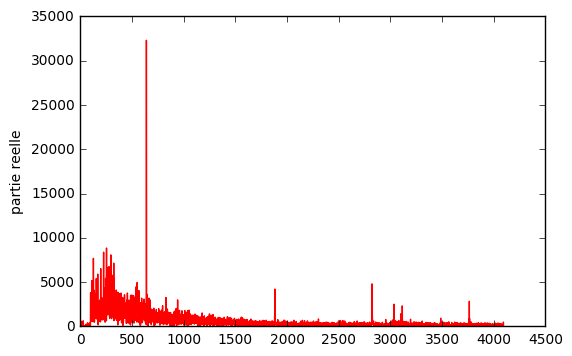

In [154]:
rawData = GetLine()
signal = np.asarray(rawData[0].split(" ")[-1].split(";EOF")[0].split(";"),dtype=int)
print len(signal)
signal[-1]= signal[-6]
for i in range(5):
    signal[-i]= signal[-6]
#data = np.asarray(rawData[1].split(" ")[-1].split(";EOF")[0].split(";"))
#dataTime = int(rawData[1].split(" ")[2]) - int(rawData[1].split(" ")[1])
FFT = np.fft.fft(signal)
for i in range(5):
    FFT[i] = 0
    FFT[-i] = 0 


for i in range(100):
    FFT[i] = FFT[i]/(100-i)
    FFT[-i] = FFT[-i]/(100-i)
    
#plt.plot(range(128),np.abs(FFT[0:128]))
plt.plot(np.abs(FFT[0:len(FFT)/2]),"r")
plt.ylabel("partie reelle")

plt.show()


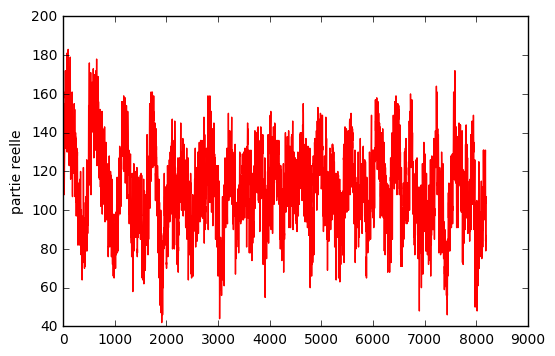

In [155]:
plt.plot(signal,"r")
plt.ylabel("partie reelle")
plt.show()

In [156]:
np.average(signal)

112.06396484375